为什么时间序列在有些数据中十分重要呢？ 想想如果你有一批按时间生产的产品，他们的销售业绩和产品质量肯定都绑定在了时间上， 如果哪几天销售好，你也可以回归过来看到底是什么原因导致的，比如节假日，购物节等等。

又或者我有一批数据出现了记录异常，比如我的网站在昨天受黑客攻击了， 我要去定位攻击的时间和影响范围，我肯定要在以时间序列记录的 log 中寻找线索。

所以时间序列不仅仅是数据的一个维度，而且也是协助数据分析的一个重要标尺。

### 读时间序列数据
我们这里通常说的时间序列是时间点的序列，比如 2022-03-13 12:22:32。看看这些数据是不是常出现在你的报表，或者 log 中？ 我们可以用 Pandas 读取文件的方式把这些带着时间序列的数据读出来， 在让 Pandas 识别这些时间序列，你就能对这些时间序列做很多事情。

比如我读出来是这样一份数据。

In [1]:
import pandas as pd

df = pd.DataFrame({
    "time": ["2022/03/12", "2022/03/13", "2022/03/14"],
    "value": [1,2,3]
})
print(df)
print("\n\ntime:\n",df["time"])

         time  value
0  2022/03/12      1
1  2022/03/13      2
2  2022/03/14      3


time:
 0    2022/03/12
1    2022/03/13
2    2022/03/14
Name: time, dtype: object


现在，Pandas 是不知道 time 这个 column 是时间序列的（现在认为它是 object）， 我们需要告诉 Pandas 把这个 time 套上时间序列的标识。

In [2]:
pd.to_datetime(df["time"])

0   2022-03-12
1   2022-03-13
2   2022-03-14
Name: time, dtype: datetime64[ns]

你看，现在它就能把这串 object 数据转换成 datetime[64] 了。这就是 Pandas 当中的 Timestamp 数据类型。 就算我的数据不是按标准格式储存的，它也能尝试帮我识别出来标准的日期格式。可见 Pandas 的强悍之处了。

In [3]:
pd.to_datetime(
    ["2022/03/12", "2022.03.13", "14/03/2022"]
)

DatetimeIndex(['2022-03-12', '2022-03-13', '2022-03-14'], dtype='datetime64[ns]', freq=None)

虽然它这么强悍，而且也能识别出非标准准的日期形式，但是输出的结果真的是你期望的吗？万一有个记录员比较有个性， 它喜欢用 月@日@年%%秒|时|分 这种形式记录日期，这么不规范，咋整？

In [4]:
pd.to_datetime(
    [
        "1@21@2022%%11|11|32", 
        "12@01@2022%%44|02|2", 
        "4@01@2022%%14|22|2"
    ],
)

ParserError: Unknown string format: 1@21@2022%%11|11|32

你试试直接解析看看，会出现什么情况？完蛋了，是不是我们就无法接下这个人留下的烂盘了？Pandas 又来拯救你了。 我们如果同时传入一个时间规则 format，有没有可能让 Pandas 按照我们的特殊规则解析？

In [5]:
pd.to_datetime(
    [
        "1@21@2022%%11|11|32", 
        "12@01@2022%%44|02|2", 
        "4@01@2022%%14|22|2"
    ],
    format="%m@%d@%Y%%%%%S|%H|%M"
)

DatetimeIndex(['2022-01-21 11:32:11', '2022-12-01 02:02:44',
               '2022-04-01 22:02:14'],
              dtype='datetime64[ns]', freq=None)

虽然看起来这串 format 很复杂，但是是可以拆解来看的，他们分别表示的是
+ %m 月
+ %d 日
+ %Y 年的全称
+ %% 比配一个 %
+ %S 秒
+ %H 时
+ %M 分  
规则太多，记不住？没事， Python 有官方文档( https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior )可以参考嘛。

### 自建时间序列
前面我们已经解决了读取到时间序列后，怎么让 Pandas 知道这是时间序列的问题。下面我们如果是要用程序采集数据，比如自己打 log， 或者自己爬虫写日期等等。你要往自己数据库中写日期。介绍一种方式批量生成时间戳。

In [7]:
import datetime

start = datetime.datetime(2022, 3, 12)
end = datetime.datetime(2022, 3, 18)

index = pd.date_range(start, end)
index

DatetimeIndex(['2022-03-12', '2022-03-13', '2022-03-14', '2022-03-15',
               '2022-03-16', '2022-03-17', '2022-03-18'],
              dtype='datetime64[ns]', freq='D')

这种写法就有点像 Python 中的 range() 函数，我们可以规定一个起始日期和终止日期，让 pd.date_range() 自动生成。 那你可能会要问了，range() 里面还有一个 step 参数可以用来控制生成的步长的。 pd.date_range() 也可以吗？

In [8]:
print(
    "range(1, 10, 2)\n", 
    list(range(1, 10, 2))
)
print(
    "\n\npd.date_range()\n",
    pd.date_range(start, end, freq="48h")
)

range(1, 10, 2)
 [1, 3, 5, 7, 9]


pd.date_range()
 DatetimeIndex(['2022-03-12', '2022-03-14', '2022-03-16', '2022-03-18'], dtype='datetime64[ns]', freq='48H')


哈哈，想到今年深圳疫情严重，去哪哪都要 48h 的核酸，我也可以做一个打卡表，来看看那些时间点需要去做核酸。只要你想，用 pandas 做一个打卡器也是没问题。 现在你可以在换一下 freq 里面的时间描述，你还可以具体到 1h20min，1D 或者是这里 列举的很多 freq 识别的缩写形式。

还有一种在 Numpy 里用的方式 np.linespace()， 这是一种在区间内均匀分割的方法，你也可以用 pd.date_range() 来模拟对日期的分割生成。

In [10]:
import numpy as np
print(
    "np.linspace(-1, 1, 5)\n",
    np.linspace(-1, 1, 5)
)
print(
    "\n\npd.date_range(start, end, periods=5)\n",
    pd.date_range(start, end, periods=5)
)

np.linspace(-1, 1, 5)
 [-1.  -0.5  0.   0.5  1. ]


pd.date_range(start, end, periods=5)
 DatetimeIndex(['2022-03-12 00:00:00', '2022-03-13 12:00:00',
               '2022-03-15 00:00:00', '2022-03-16 12:00:00',
               '2022-03-18 00:00:00'],
              dtype='datetime64[ns]', freq=None)


pd.date_range() 对于时间个规则性生成还是很友善的。如果你处理工作日比较多，可以参考看看这个 pd.bdate_range() 函数(https://pandas.pydata.org/docs/reference/api/pandas.bdate_range.html?highlight=bdate_range#pandas.bdate_range )， 它会打开你的眼界。

### 选取时间
读取完数据，生成完数据，也只是对数据的识别而已， 而现在我们要进入对时间数据的选取阶段，来看怎么选数据的问题。 因为有了这个阶段，我们才能真正开始对时间进行运算。

In [11]:
start = datetime.datetime(2022, 3, 1)
end = datetime.datetime(2022, 5, 3)

rng = pd.date_range(start, end)
ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts.index

DatetimeIndex(['2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04',
               '2022-03-05', '2022-03-06', '2022-03-07', '2022-03-08',
               '2022-03-09', '2022-03-10', '2022-03-11', '2022-03-12',
               '2022-03-13', '2022-03-14', '2022-03-15', '2022-03-16',
               '2022-03-17', '2022-03-18', '2022-03-19', '2022-03-20',
               '2022-03-21', '2022-03-22', '2022-03-23', '2022-03-24',
               '2022-03-25', '2022-03-26', '2022-03-27', '2022-03-28',
               '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01',
               '2022-04-02', '2022-04-03', '2022-04-04', '2022-04-05',
               '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-09',
               '2022-04-10', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-15', '2022-04-16', '2022-04-17',
               '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21',
               '2022-04-22', '2022-04-23', '2022-04-24', '2022-04-25',
      

注意，我在生成 Series 的时候，把时间序列挂到了 Series 的 index 上，到时候也可以用这个来作为画图的坐标。

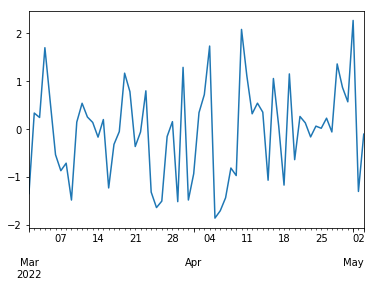

In [13]:
import matplotlib
%matplotlib inline
ts.plot()

画图出来，就能发现，横坐标已经打上了时间标签。 如果我们不想要一次性展示这么多数据怎么办？如果我们只想要显示某一周时间的数据怎么办？那直接上分片原则吧。

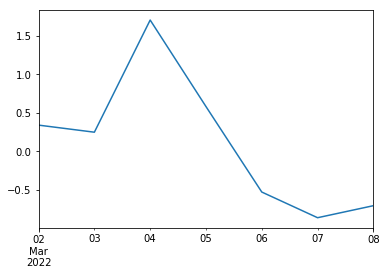

In [14]:
ts[1:8].plot()

直接用 index 看起来不好弄？不知道到底 index 对应的是哪个日期区间？没关系，我们试试用时间本身分片。

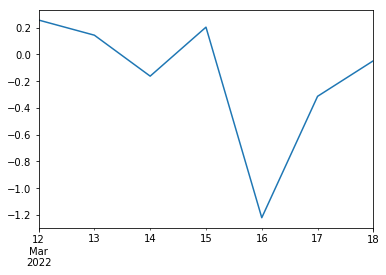

In [15]:
import datetime

t1 = datetime.datetime(2022, 3, 12)
t2 = datetime.datetime(2022, 3, 18)
ts[t1: t2].plot()

还想继续偷懒，我们直接上日期字符串做索引吧。

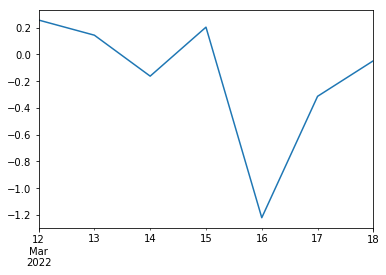

In [16]:
ts["2022-03-12": "2022-03-18"].plot()

Pandas 的用法可为是真的强大，提供的方式真的很多样！

### 时间运算
选择时间数据也会了，那我们就来看看如何对时间进行运算吧。这通常发生在需要改变日期数值的时候，比如我想复制一份这周的表格，给下周用， 我就直接将这个月 copy 过来，然后日期上加一周时间。

In [17]:
rng = pd.date_range("2022-01-01", "2022-01-07")
rng + pd.Timedelta(weeks=1)

DatetimeIndex(['2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11',
               '2022-01-12', '2022-01-13', '2022-01-14'],
              dtype='datetime64[ns]', freq='D')

Timedelta 是一种用于时间加减的时间单位，我们可以个任何一个 Timestamp 加减一个时间。而且 Timedelta 还可以乘除。

In [18]:
rng + 2*pd.Timedelta(days=3)

DatetimeIndex(['2022-01-07', '2022-01-08', '2022-01-09', '2022-01-10',
               '2022-01-11', '2022-01-12', '2022-01-13'],
              dtype='datetime64[ns]', freq='D')

Timedelta 除了上面的 weeks, days 参数，还可以用 hours, minutes, seconds, milliseconds, microseconds, nanoseconds 这些。 这样你就能方便的运算时间了。

有时候我都觉得用 Pandas 算日期，比用 Python 原生的 datetime 还要方便。比如下面这些：

In [19]:
rng = pd.date_range("2022-01-08", "2022-01-11")
rng.dayofyear

Int64Index([8, 9, 10, 11], dtype='int64')

用上面的方法，再试试这几个：rng.dayofweek; rng.weekofyear; rng.weekday。

In [20]:
rng.strftime("%m/%d/%Y")  # 按规则输出日期形式

Index(['01/08/2022', '01/09/2022', '01/10/2022', '01/11/2022'], dtype='object')

用上面的模式，再试试这几个：dt.day_name(); dt.month_name()。

当然除了上面的这些方便的转换方法，官方还为我们提供了丰富的转换方式，只要你需要， 你能在这里又发现 Timestamp 转换的一片天地。

### 时区
如果你的操作系统没配置好，有或者你在其他时区，但有想处理另外的时区。那么学会配置 Pandas 的时区就是一件很重要的事。

In [21]:
rng = pd.date_range("2022-01-08", "2022-01-11")

rng.tz is None


True

默认生成的时候，是不带时区的。所以当你要跨半球工作，你在处理 excel 读取出来的时间，或者你自己要控制时间的时候， 你就要特别标注好时区 tz_localize()。

In [22]:
s = pd.to_datetime(
    ["2022/03/12 22:11", "2022/03/12 12:11", "2022/03/12 2:11"]
)
s_us = s.tz_localize("America/New_York")
s_us

DatetimeIndex(['2022-03-12 22:11:00-05:00', '2022-03-12 12:11:00-05:00',
               '2022-03-12 02:11:00-05:00'],
              dtype='datetime64[ns, America/New_York]', freq=None)

上面我读取到了数据之后，因为老板告诉我这是 New York 时区， 区分于中国时区，我必须先标注是 America/New_York，以防我到时候时间记录错误。 如果要转换到中国时区，我们就可以用下面 tz_convert() 这种方法。

In [23]:
s_cn = s_us.tz_convert("Asia/Shanghai")
s_cn

DatetimeIndex(['2022-03-13 11:11:00+08:00', '2022-03-13 01:11:00+08:00',
               '2022-03-12 15:11:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq=None)

你问我为什么用 Shanghai 不用 Beijing？因为下面用于时区标记中，没有北京。哈哈。

In [24]:
import pytz
pytz.country_timezones('CN')

['Asia/Shanghai', 'Asia/Urumqi']

同理，你要获取对应的时区名称，你可以用 pytz 这个库来看。 请参考这里的文档(http://pytz.sourceforge.net/# )。

当你自己要生成一批时间的时候，带上时区的方法就比较简单。直接在 pd.date_range() 里带上 tz 的描述。

In [25]:
rng = pd.date_range(
    "2022-01-08", "2022-01-11", 
    tz="America/New_York")
rng

DatetimeIndex(['2022-01-08 00:00:00-05:00', '2022-01-09 00:00:00-05:00',
               '2022-01-10 00:00:00-05:00', '2022-01-11 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', freq='D')

### 总结
不可不说，时间真是一件大工程，围绕时间的处理工作，我也只介绍了冰山一角。还有很多可以在官方文档中查看到， 比如工作日的计算，很多很丰富，但是我觉得你可能很少用，所以就先不介绍了， 有兴趣的朋友可以看看这里的官方文档， 去探索更加全面的时间处理方式吧。